# Assignment 2C preprocessing
### Description
In this assignment you have to build a multimodal deep neural network for emotion detection using tf.keras. You have to work with the RAVDESS dataset, which contains short (~4 seconds long) video clip recordings of speakers, who are acting the different emotions through 2 sentences. We will extract and combine RGB frames with MFCCs and utilize both video and audio information sources to achieve a better prediction.

### Import libraries

In [1]:
import cv2
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tqdm

#### RAVDESS License and brief summary

License information

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
Filename example: 02-01-06-01-02-01-12.mp4

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement “dogs” (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

#### Index dataset
In order to access the dataset, a pandas.Dataframe will contain the required information.

In [2]:
audio_folders = []
video_folders = []
audio_file_names = []
video_file_names = []
#formats = []

labels = []

audio_root = "./ravdess/audio_trim"
video_root = "./ravdess/video_trim"

for root, dirs, files in os.walk(audio_root, topdown=False):
    for file in files:
        audio_folders.append(root)
        audio_file_names.append(file)
        #audio_file_names.append(file.split('.')[0])
        #formats.append(file.split('.')[-1])

count = 0
for root, dirs, files in os.walk(video_root, topdown=False):
    for file in files:
        # only the videos with audio
        if file.split('-')[0] == '01':
            count += 1
            video_folders.append(root)
            video_file_names.append(file)
            #video_file_names.append(file.split('.')[0])
            #formats.append(file.split('.')[-1])
            labels.append(int(file.split('-')[2]))

dataset = pd.DataFrame()
dataset['audio_folder'] = audio_folders
dataset['audio_file_name'] = audio_file_names
dataset['video_folder'] = video_folders
dataset['video_file_name'] = video_file_names
#dataset['format'] = formats
dataset['label'] = labels
dataset.head()

,audio_folder,audio_file_name,video_folder,video_file_name,label
0,./ravdess/audio_trim\Actor_01,03-01-01-01-01-01-01.wav,./ravdess/video_trim\Actor_01,01-01-01-01-01-01-01.mp4,1
1,./ravdess/audio_trim\Actor_01,03-01-01-01-01-02-01.wav,./ravdess/video_trim\Actor_01,01-01-01-01-01-02-01.mp4,1
2,./ravdess/audio_trim\Actor_01,03-01-01-01-02-01-01.wav,./ravdess/video_trim\Actor_01,01-01-01-01-02-01-01.mp4,1
3,./ravdess/audio_trim\Actor_01,03-01-01-01-02-02-01.wav,./ravdess/video_trim\Actor_01,01-01-01-01-02-02-01.mp4,1
4,./ravdess/audio_trim\Actor_01,03-01-02-01-01-01-01.wav,./ravdess/video_trim\Actor_01,01-01-02-01-01-01-01.mp4,2


In [3]:
len(dataset)

1440

In [4]:
EMOTIONS = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

#### Librosa test
Test waveplot to get familiar with librosa library

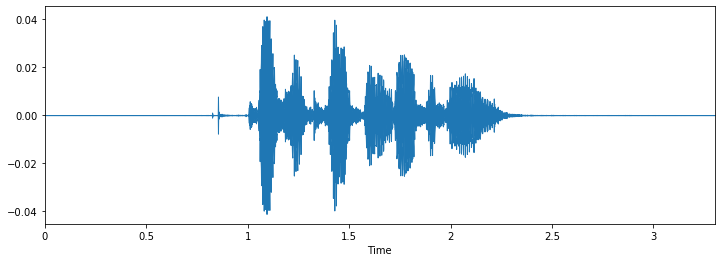

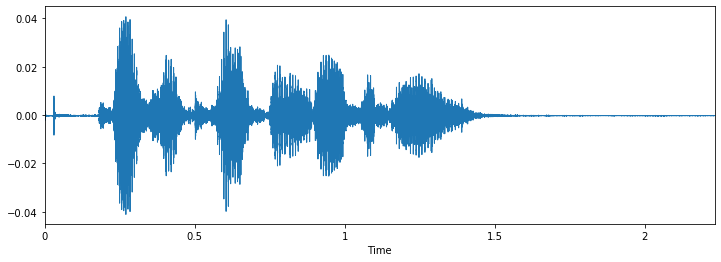

In [5]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('./ravdess/audio/Actor_01/03-01-01-01-01-01-01.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()


data, sampling_rate = librosa.load('./ravdess/audio_trim/Actor_01/03-01-01-01-01-01-01.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()



In [6]:
hop_length = int(sampling_rate/100)
n_fft = int(sampling_rate/40)
features_librosa = librosa.feature.mfcc(data, sampling_rate, n_mfcc=40, hop_length=hop_length, n_fft=n_fft)

In [7]:
features_librosa[0][0]

-876.2726

#### Audio representation
For each audio file, we will extract a 40 MFCC

In [8]:
N_MFCC = 40

audio_features_list = []

for index, row in tqdm.tqdm(dataset.iterrows(), total=dataset.shape[0]):
    data, sampling_rate = librosa.load(os.path.join(row['audio_folder'], row['audio_file_name']))
    hop_length = int(sampling_rate/100)
    n_fft = int(sampling_rate/N_MFCC)
    features_librosa = librosa.feature.mfcc(data, sampling_rate, n_mfcc=N_MFCC, hop_length=hop_length, n_fft=n_fft)
    audio_features_list.append(features_librosa)

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [03:06<00:00,  7.73it/s]


#### Calculate the mean number of spectral frames, Standardize the MFCC sample-wise and use pre-padding to unify the lengths

In [9]:
maxValue = 0
total = 0
for f in audio_features_list:
    if f.shape[1] > maxValue: maxValue = f.shape[1]
    total += f.shape[1]

print("The max value is: ",maxValue)
print("The mean number of spectral frames is: ",total/len(audio_features_list))

padded_features_list = []
for f in audio_features_list:
    f = (f - np.mean(f)) / np.std(f)
    
    print("Mean: %f" % np.mean(f))
    print("Standard deviation: %f" % np.std(f))
    
    pad_mask = np.zeros((N_MFCC,maxValue))
    pad_mask[:f.shape[0],:f.shape[1]] = f
    padded_features_list.append(pad_mask)

padded_features_list[3].shape

The max value is:  502
The mean number of spectral frames is:  279.56666666666666
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard d

Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standar

Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Sta

Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation:

Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standar

Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: 0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000000
Mean: -0.000000
Standard deviation: 1.000

(40, 502)

In [10]:
audio_features_arr = np.array(padded_features_list)

audio_features_arr = np.expand_dims(audio_features_arr, axis=3)

#### Audio representation per sample is a tensor with shape (N_COEFFICIENTS, MAX_N_FRAMES, 1)

In [11]:
print("Audio features shape:",audio_features_arr.shape)

Audio features shape: (1440, 40, 502, 1)


#### Video representation
For each video file, we will subsample 6 frames to reduce complexity, extract the face from the image and resize it to (64,64,3)

In [12]:
net = cv2.dnn.readNetFromCaffe("./face_detection/detection_deploy.prototxt.txt", 
        "./face_detection/detection_res10_300x300_ssd_iter_140000.caffemodel")

In [13]:
DESIRED_N_FRAMES = 6
IMAGE_SIZE = (64,64)

video_features_list = []

for index, row in tqdm.tqdm(dataset.iterrows(), total=dataset.shape[0]):
    '''
    - remove beginning and end silences
    - extract the faces from the images. (Tips: You can use the cv2.CascadeClassifier, 
        or the DLIB package to determine facial keypoints, or MTCNN to predict bounding boxes.)
    - resize the face images to 64x64. (Tips: You can use lower/higher resolution as well.)
    - subsample the frames to reduce complexity (6 frames/video is enough)
    
    only then, save frames to disk
    '''
    vidcap = cv2.VideoCapture(os.path.join(row['video_folder'], row['video_file_name']))
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    module = int(length / DESIRED_N_FRAMES)
    
    success, image = vidcap.read()
    count = 0
    
    frame_list = []
    
    while success:
        if (count % module) == 0 and (len(frame_list) < 6):
            # Process frame
            
            #image = cv2.resize(image, IMAGE_SIZE)
            
            scale_percent = 40
            w = int(image.shape[1] * scale_percent / 100)
            h = int(image.shape[0] * scale_percent / 100)
            
            blob = cv2.dnn.blobFromImage(cv2.resize(image, (w,h)), 1.0, (w,h), (104.0, 177.0, 123.0))
            net.setInput(blob)
            detections = net.forward()
            
            box = detections[0, 0, 0, 3:7] * np.array([w,h,w,h])
            
            (startX, startY, endX, endY) = box.astype("int")
            
            if (detections[0,0,0,2] < 0.4) or (startX-endX == 0) or (startY-endY == 0):
                frame_list.append(cv2.resize(image, IMAGE_SIZE))
            else:
                face = cv2.resize(image, (w,h))[startY:endY, startX:endX]
                face = cv2.resize(face, IMAGE_SIZE)

                frame_list.append(face)
            
        success, image = vidcap.read()
        count +=1
    
    video_features_list.append(np.array(frame_list))

video_features_arr = np.array(video_features_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [24:28<00:00,  1.02s/it]


#### Video representation per sample is a tensor with shape (N_FRAMES, 64, 64, 3)

In [14]:
video_features_arr.shape

(1440, 6, 64, 64, 3)

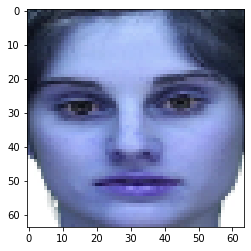

In [15]:
plt.imshow(frame_list[0])

<Figure size 432x288 with 0 Axes>

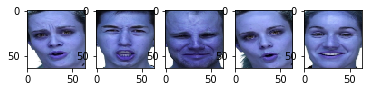

In [16]:
import random

n_images = 5

plt.figure()
f, axarr = plt.subplots(1,n_images)
for i in range(n_images):
    r0 = random.randint(0,video_features_arr.shape[0]-1)
    r1 = random.randint(0,video_features_arr.shape[1]-1)    
    axarr[i].imshow(video_features_arr[r0][r1])
plt.show()

#### We also generate the corresponding labels of the dataset

In [17]:
data_labels = dataset['label']
data_labels = data_labels.to_numpy()

In [18]:
print("Audio representation shape:",audio_features_arr.shape)
print("Video representation shape:",video_features_arr.shape)
print("Labels shape:",data_labels.shape)

Audio representation shape: (1440, 40, 502, 1)
Video representation shape: (1440, 6, 64, 64, 3)
Labels shape: (1440,)


#### Apply normalization to the image data

In [19]:
video_features_arr_norm = video_features_arr / 255

In [20]:
#import ffmpeg
#import subprocess
#ffmpeg.input(os.path.join(dataset.iloc[1440]['folder'], dataset.iloc[1440]['file_name'] + '.' + dataset.iloc[1440]['format'])).filter('silencedetect', n='{}dB'.format(-60), d=0.3).output('-', format='null').compile()
#subprocess.Popen(ffmpeg.input(os.path.join(dataset.iloc[1440]['folder'], dataset.iloc[1440]['file_name'] + '.' + dataset.iloc[1440]['format'])).filter('silencedetect', n='{}dB'.format(-60), d=0.3).output('-', format='null').compile())

In [21]:
labels = (data_labels - 1) - ((data_labels - 1) > 0).astype(int)

In [22]:
np.save("./ravdess/data", {'index': dataset,
                           'audio_features': audio_features_arr, 
                           'video_features': video_features_arr_norm, 
                           'labels': labels}, 
        allow_pickle=True, fix_imports=True)